In [1]:
import cv2
from scipy.ndimage import distance_transform_edt as dist
import IPython.display 
import importlib
import skimage.io as imgio
import numpy as np
import os
import torch
import torch.nn.functional as F
import math
import re
from matplotlib import pyplot as plt
from scipy import ndimage
from topoloss4neurons.networks import UNet
import networktraining as nt
import os
import tifffile
import skimage
from utils import getCube, findCubes, getCubeCoords
from tqdm import tqdm
%matplotlib inline
# %matplotlib notebook

path_apls: /cvlabdata1/home/zakariya/SegmentingBrains


In [2]:
def loadTahaPred(brain_i, cube):
    """
    Returns the prediction of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    elif brain_i == 225:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL225"
    elif brain_i == 250:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL250"
    elif brain_i == 177:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL177"

    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    pred = np.load(os.path.join(direc,l1,l2,l3)).transpose(2,0,1)
    return pred

In [3]:
def create_processed_cube_list(brain_i, path):

    cubes = []
    xs,ys,zs = getCubeCoords(brain_i)
    
    for folder_y in os.listdir(path):
        for folder_x in os.listdir(f'{path}/{folder_y}'):
            for file_yxz in os.listdir(f'{path}/{folder_y}/{folder_x}'):
                
                y = int(folder_y)//10
                x = int(folder_x.split("_")[-1])//10
                z = int(file_yxz.split("_")[-1][:-4])//10
                
                y = np.where(np.array(ys)==y)[0][0]
                x = np.where(np.array(xs)==x)[0][0]
                z = np.where(np.array(zs)==z)[0][0]
                
                cubes.append([x,y,z])
    
    return cubes

In [4]:
cubes = create_processed_cube_list(177, '/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL177')

In [5]:
def createGray_clip_expo(im, pred, lmbd=0.5):
    # clipping ...
    
    pred = np.clip(pred, a_min=pred.min(), a_max=6)
    pred = (pred.max() - pred)/pred.max()
    pred = np.power(pred, 2)
    pred /= pred.max()
    
    tmp = im.max()
    im = (im / im.max() * 255).astype(np.uint8)
    
    finalim = ((lmbd*pred*255) + im)
    finalim /= finalim.max()/tmp

    return finalim.astype(np.int16)

def createRGB_clip_expo(im, pred, lmbd=0.5):
    
    g_channel = np.clip(pred, a_min=pred.min(), a_max=6)
    g_channel = np.array((g_channel.max() - g_channel)/g_channel.max())
    g_channel = np.power(g_channel, 2)
    g_channel /= g_channel.max()
    
    
    finalim = np.zeros((im.shape[0], im.shape[1], im.shape[2], 3))
    finalim[:,:,:,0] = im.astype(np.int16)
    finalim[:,:,:,2] = im.astype(np.int16)
    finalim[:,:,:,1] = (g_channel * 65535 * 0.8).astype(np.int16)
    
    return finalim.astype(np.int16)


def createGray(im, pred, lmbd=0.5):
    # clipping ...
    pred = (pred.max() - pred)/pred.max()
    tmp = im.max()
    im = (im / im.max() * 255).astype(np.uint8)
    
    finalim = ((lmbd*pred*255) + im)
    finalim /= finalim.max()/tmp

    return finalim.astype(np.int16)

In [6]:
dims = np.array(cubes).max(0) - np.array(cubes).min(0) +1
maxs = np.array(cubes).max(0)
mins = np.array(cubes).min(0)

In [51]:
cubes

[[8, 32, 4],
 [8, 32, 3],
 [8, 32, 5],
 [8, 32, 6],
 [7, 32, 4],
 [7, 32, 3],
 [7, 32, 5],
 [7, 32, 6],
 [9, 32, 4],
 [9, 32, 3],
 [9, 32, 5],
 [6, 32, 4],
 [6, 32, 5],
 [6, 32, 3],
 [10, 32, 4],
 [10, 32, 3],
 [10, 32, 5],
 [5, 32, 4],
 [5, 32, 5],
 [5, 32, 3],
 [11, 32, 4],
 [11, 32, 3],
 [11, 32, 5],
 [11, 32, 6],
 [4, 32, 4],
 [4, 32, 3],
 [4, 32, 5],
 [12, 32, 4],
 [12, 32, 3],
 [12, 32, 2],
 [12, 32, 7],
 [3, 32, 4],
 [3, 32, 3],
 [13, 32, 3],
 [13, 32, 4],
 [13, 32, 5],
 [13, 32, 2],
 [13, 32, 7],
 [14, 32, 3],
 [14, 32, 4],
 [14, 32, 5],
 [14, 32, 2],
 [14, 32, 7],
 [15, 32, 3],
 [15, 32, 2],
 [15, 32, 7],
 [15, 32, 8],
 [16, 32, 3],
 [16, 32, 4],
 [16, 32, 5],
 [16, 32, 2],
 [16, 32, 7],
 [17, 32, 3],
 [17, 32, 2],
 [18, 32, 2],
 [18, 32, 3],
 [18, 32, 1],
 [19, 32, 2],
 [19, 32, 1],
 [20, 32, 2],
 [20, 32, 3],
 [20, 32, 1],
 [21, 32, 2],
 [21, 32, 1],
 [22, 32, 2],
 [22, 32, 1],
 [23, 32, 2],
 [23, 32, 1],
 [23, 32, 0],
 [24, 32, 2],
 [24, 32, 1],
 [24, 32, 0],
 [25, 32, 2],


In [74]:
def create_grayscale_plot(brain_i, cube):
    pred = loadTahaPred(brain_i, cube)
    
    im = getCube(brain_i, cube)/65535
    im = im*255
    
    
    return im.astype('uint8').max(2), pred.min(2)

In [75]:
brain_i = 177

In [79]:
im1, pred1 = create_grayscale_plot(brain_i, [31, 29, 2])
im2, pred2 = create_grayscale_plot(brain_i, [8, 32, 4])
im3, pred3 = create_grayscale_plot(brain_i, [28, 36, 1])

In [80]:
predss = []
predss.append(im1)
predss.append(pred1)
predss.append(im2)
predss.append(pred2)
predss.append(im3)
predss.append(pred3)

len(predss)

6

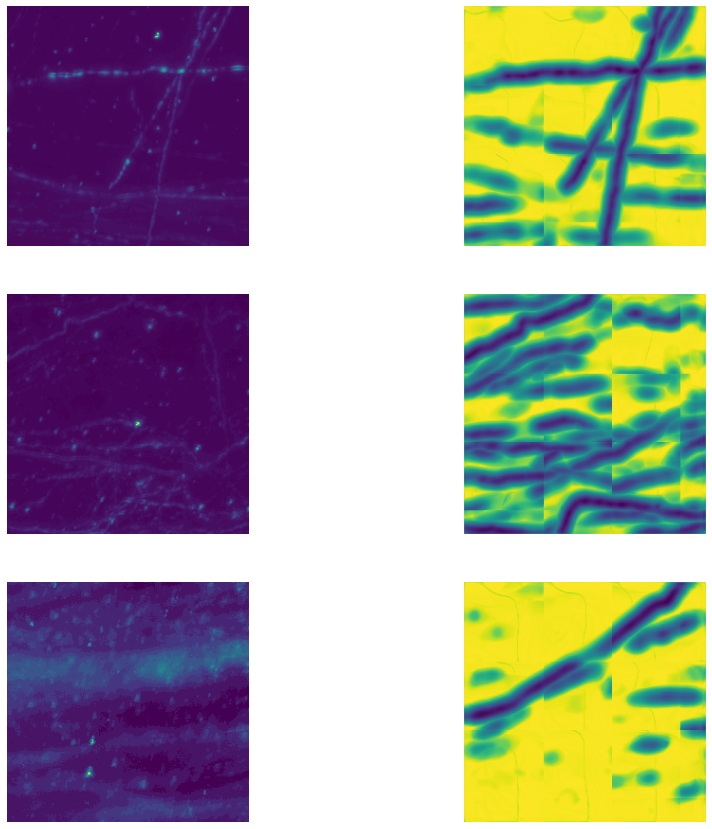

In [81]:
plt.figure(figsize=(15, 15))

# loop through the length of tickers and keep track of index
for n, pre in enumerate(predss):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)

    # filter df and plot ticker on the new subplot axis
    plt.imshow(pre)

    # chart formatting
    plt.axis('off')